In [26]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob
import os
from ripple_heterogeneity.utils import functions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels' #change to v7
functions.set_plotting_defaults()

## find data files

In [2]:

files = glob.glob(r"Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_analysis\**/*.csv",recursive=True)

dirnames = [os.path.dirname(file) for file in files]
dirnames = np.unique(dirnames)

## load data

In [16]:
df = pd.DataFrame()
for dirname in dirnames:
    layer_id = pd.read_csv(glob.glob(os.path.join(dirname,"*layerID.csv"))[0])

    red_cells_file = glob.glob(os.path.join(dirname,"*redcells.csv"))
    green_cells_file = glob.glob(os.path.join(dirname,"*greencells.csv"))
    calb_cells_file = glob.glob(os.path.join(dirname,"*calb.csv"))

    if len(red_cells_file) > 0:
        df_temp = pd.read_csv(red_cells_file[0])
        df_temp["color"] = "Red-Calb"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(green_cells_file) > 0:
        df_temp = pd.read_csv(green_cells_file[0])
        df_temp["color"] = "Green-Calb"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(calb_cells_file) > 0:
        df_temp = pd.read_csv(calb_cells_file[0])
        df_temp["color"] = "Calb"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    df.loc[df.folder_name == dirname,"layer_rad_y"] = layer_id.Y.iloc[0]
    df.loc[df.folder_name == dirname,"layer_or_y"] = layer_id.Y.iloc[1]

df["normalized_dist"] = np.abs(df.Y - df.layer_rad_y) / abs(df.layer_rad_y - df.layer_or_y)
df

,,Area,Mean,Min,Max,X,Y,Ch,Slice,color,folder_name,layer_rad_y,layer_or_y,normalized_dist
0,1,0.0,392,392,392,229.494,181.153,1,1,Red-Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.223314
1,2,0.0,488,488,488,131.200,172.926,1,1,Red-Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.318324
2,3,0.0,310,310,310,94.563,171.400,1,1,Red-Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.335947
3,4,0.0,438,438,438,260.959,174.453,1,1,Red-Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.300689
4,5,0.0,394,394,394,38.588,160.205,1,1,Red-Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.465233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,27,0.0,9310,9310,9310,113.844,200.748,1,12,Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.226162
688,28,0.0,6696,6696,6696,216.970,168.883,1,8,Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.525891
689,29,0.0,4600,4600,4600,190.899,164.249,1,8,Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.569479
690,30,0.0,3944,3944,3944,11.877,143.971,1,4,Calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.760217


## plot smoothed distribution of distances per projection type

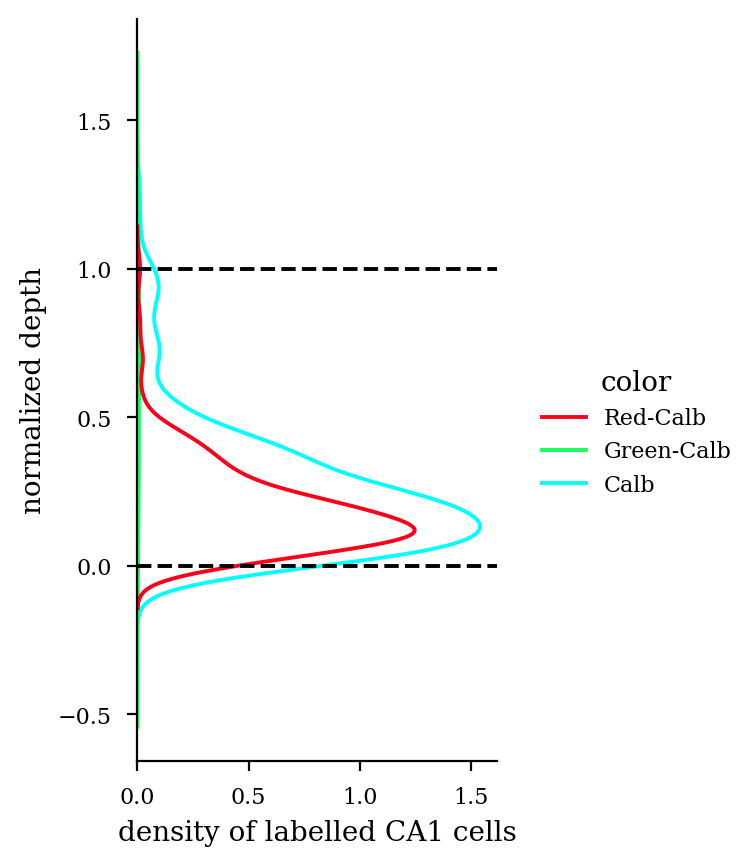

In [19]:
h,w = functions.set_size("thesis", fraction=.75, subplots=(1, 1))

group_colors = {"Red-Calb": "#f9021a", "Green-Calb": "#18ff5e","Calb":"#00FFFF"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.displot(df, y="normalized_dist", hue="color",hue_order=group_colors, kind="kde", fill=False,common_norm=True,height=h,aspect=w/h,alpha=1)
plt.axhline(0,color="k",linestyle="--")
plt.axhline(1,color="k",linestyle="--")
plt.xlabel("Density of labelled CA1 cells")
plt.ylabel("Normalized depth")

plt.savefig(os.path.join(fig_save_path,'Normalized_depth_labelled_CA1_cells_Calb.svg'),dpi=300,bbox_inches='tight')


## rank sum test between green and red distance

In [21]:
red_green_ranksums=ranksums(df.query("color=='Red-Calb'").normalized_dist,df.query("color=='Green-Calb'").normalized_dist)
red_calb_ranksums=ranksums(df.query("color=='Red-Calb'").normalized_dist,df.query("color=='Calb'").normalized_dist)
green_calb_ranksums=ranksums(df.query("color=='Green-Calb'").normalized_dist,df.query("color=='Calb'").normalized_dist)

print(red_green_ranksums)
print(red_calb_ranksums)
print(green_calb_ranksums)


RanksumsResult(statistic=-3.117677188783434, pvalue=0.0018228233820047634)
RanksumsResult(statistic=-2.5206303672842307, pvalue=0.011714483543515663)
RanksumsResult(statistic=2.6995084589236393, pvalue=0.006944199041847074)


##Z test between red, green and calb distances


In [22]:
Z test

In [25]:



red_green_zscore=zscore(df.query("color=='Red-Calb'").normalized_dist,df.query("color=='Green-Calb'").normalized_dist)



red_calb_zscore=zscore(df.query("color=='Red-Calb'").normalized_dist,df.query("color=='Calb'").normalized_dist)



green_calb_zscore=zscore(df.query("color=='Green-Calb'").normalized_dist,df.query("color=='Calb'").normalized_dist)

print(red_green_zscore)
print(red_calb_zscore)
print(green_calb_zscore)


TypeError: 'Series' object cannot be interpreted as an integer

## get proportions of cells 

## get proportions of cells 

In [27]:
prop_df = df.groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1

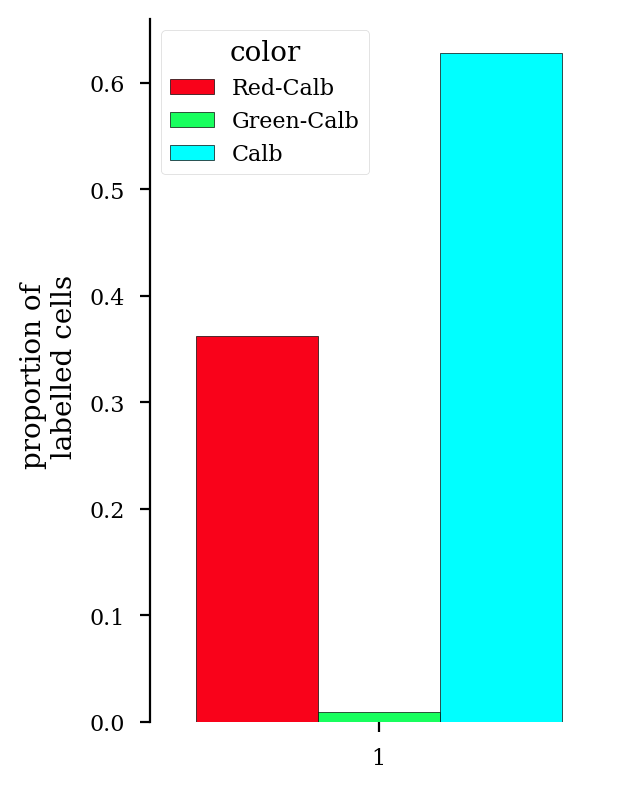

In [28]:
plt.figure(figsize = functions.set_size("thesis", fraction=.5, subplots=(2.5, 1)))

sns.barplot(data=prop_df,x="constant", hue="color", y="prop",hue_order=group_colors,edgecolor="k",saturation=1)
sns.despine(bottom=True)
plt.ylabel("proportion of \n labelled cells")
plt.xlabel("")
plt.savefig(os.path.join(fig_save_path,'prop_of_labelled_cells_calb.svg'),dpi=300,bbox_inches='tight')


## make distribution plot for each animal